# Shallow CNN for EEG Decoding
The goals for this notebook are:
* Do some exploration on the dataset
* Build the shallow CNN described on Schirrmeister et al.

## Data Exploration
Take a look at the dataset and understand the data.

First let's import tf/keras and all the packages needed.

In [36]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers

In [37]:
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.0


Load dataset and check dimensions.

In [38]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import os
os.chdir("/content/drive/MyDrive/c247/data")

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [40]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


Adjust the labels so that they're in the 0-4 range.

In [41]:
y_train_valid -= 769
y_test -= 769

### Training/test data
There are 2115 trials on the training data and 443 trials on the test data; each trial has data from 22 electrodes over 1000 time bins.

Plot the data for some of the trials and electrodes (channels).


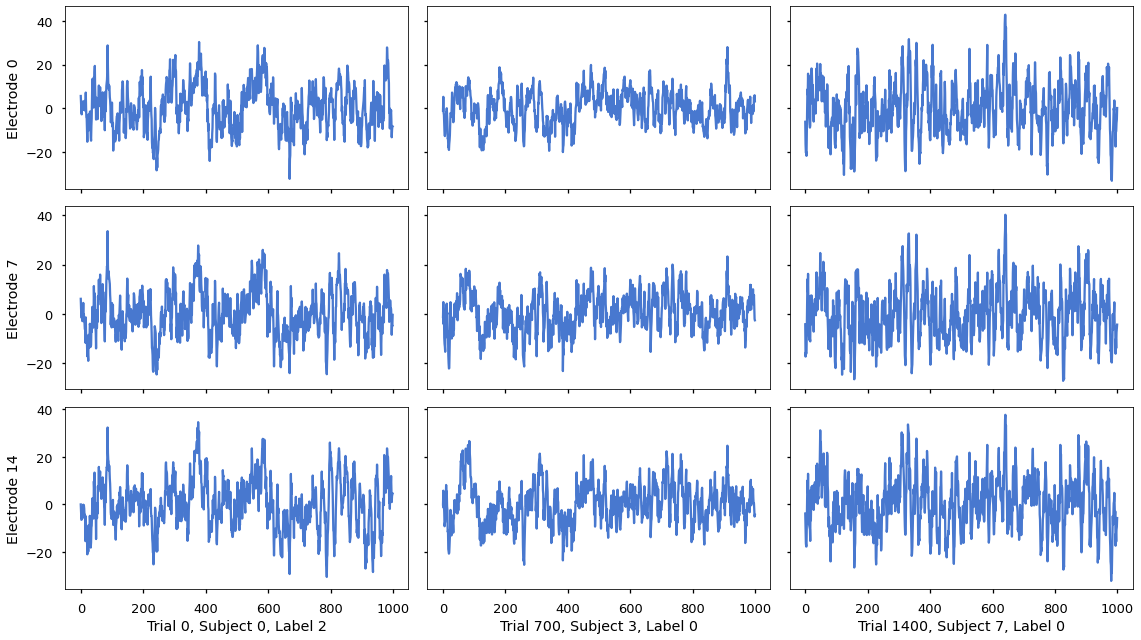

In [42]:
plt.style.use(['seaborn-muted', 'seaborn-talk'])
plt.rcParams['figure.figsize'] = (16,9)

num_channels = 3
num_trials = 3
fig, ax = plt.subplots(num_channels, num_trials, sharex='col', sharey='row')
for i in range(num_trials):
  for j in range(num_channels):
    ax[j,i].plot(X_train_valid[i*700,j*7,:].T)
    if j == len(ax) - 1:
      ax[j,i].set_xlabel(f'Trial {i*700}, '
                         f'Subject {int(person_train_valid[i*700,0])}, '
                         f'Label {y_train_valid[i*700]}')
    if i == 0:
      ax[j,i].set_ylabel(f'Electrode {j*7}')
plt.tight_layout()

The plots show that the waveforms for each trial across electrodes/channels are very similar to each other. This could be some sort of common mode noise across all electrodes.

## Data Pre-processing
We should consider pre-processing the data as described on Schirrmeister et al. 

* What kind of pre-processing should we do? This might become more apparent as we begin to train models and see some results.

## Basic CNN model
Let's build a basic CNN model using keras/tensorflow implementing the architecture of the shallow CNN model described on [Schirrmeister et al](https://arxiv.org/pdf/1703.05051.pdf).
Slides presented in lecture include an implementation of this paper.



Define new activation functions described on the paper.

In [43]:
def ksquare(x):
  return tf.pow(x, 2)

def klog(x):
  return tf.math.log(x)

Define the model using the functional API.

Dimensions for each layer:
* **Input layer**: 22 channels, 1000 time bins `(22, 1000)` 

In [44]:
# Input layer is used to instantiate a tensor
# Dimensions are (E,T) -> (22, 1000)
input_ = layers.Input(shape=(22, 1000))

# Reshape layer reshapes input into given shape
# output shape is (batch_size,) + target_shape
r1 = layers.Reshape(target_shape=(22, 1000, 1))(input_)

# Temporal convolution layer
# kernel_size is (H,W)
# for channels_last input is a 4D-tensor with dims batch_size + (rows, cols, )
c1 = layers.Conv2D(filters=40, kernel_size=(1,25), data_format='channels_last',
                   activation='elu')(r1)

# Permute layer
p1 = layers.Permute(dims=(2,1,3))(c1)

# Reshape layer
r2 = layers.Reshape((976, 22*40))(p1)

# FC layer
d1 = layers.Dense(40, activation='elu')(r2)

# Activation layer using ksquare
sq1 = layers.Activation(ksquare)(d1)

# Mean pooling layer
ap1 = layers.AveragePooling1D(75, strides=15)(sq1)

# Log activation layer
log1 = layers.Activation(klog)(ap1)

# Flatten layer
f1 = layers.Flatten()(log1)

# Output layer
output_ = layers.Dense(4, activation='softmax')(f1)

In [45]:
model = models.Model(inputs=input_, outputs=output_, name='shallow_covnet')
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

In [46]:
model.summary()

Model: "shallow_covnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 22, 1000)]        0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 22, 1000, 1)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 976, 40)       1040      
_________________________________________________________________
permute_4 (Permute)          (None, 976, 22, 40)       0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 976, 880)          0         
_________________________________________________________________
dense_6 (Dense)              (None, 976, 40)           35240     
_________________________________________________________________
activation_6 (Activation)    (None, 976, 40)        

In [47]:
loss_hist = model.fit(X_train_valid, y_train_valid, 
                      validation_split=0.2, epochs=250,
                      verbose=True)

Epoch 1/250
53/53 [==============================] - 34s 630ms/step - loss: 1.8499 - acc: 0.3025 - val_loss: 1.3392 - val_acc: 0.3759
Epoch 2/250
53/53 [==============================] - 33s 625ms/step - loss: 1.1888 - acc: 0.4933 - val_loss: 1.2725 - val_acc: 0.4208
Epoch 3/250
53/53 [==============================] - 34s 634ms/step - loss: 1.0085 - acc: 0.6066 - val_loss: 1.2398 - val_acc: 0.4799
Epoch 4/250
53/53 [==============================] - 34s 635ms/step - loss: 0.8756 - acc: 0.6569 - val_loss: 1.1895 - val_acc: 0.5154
Epoch 5/250
53/53 [==============================] - 34s 634ms/step - loss: 0.7739 - acc: 0.7052 - val_loss: 1.1041 - val_acc: 0.5390
Epoch 6/250
53/53 [==============================] - 34s 637ms/step - loss: 0.6524 - acc: 0.7790 - val_loss: 1.1791 - val_acc: 0.5225
Epoch 7/250
53/53 [==============================] - 34s 635ms/step - loss: 0.6012 - acc: 0.7802 - val_loss: 1.1031 - val_acc: 0.5603
Epoch 8/250
53/53 [==============================] - 34s 636ms

Plot the loss history and the accuracy history.

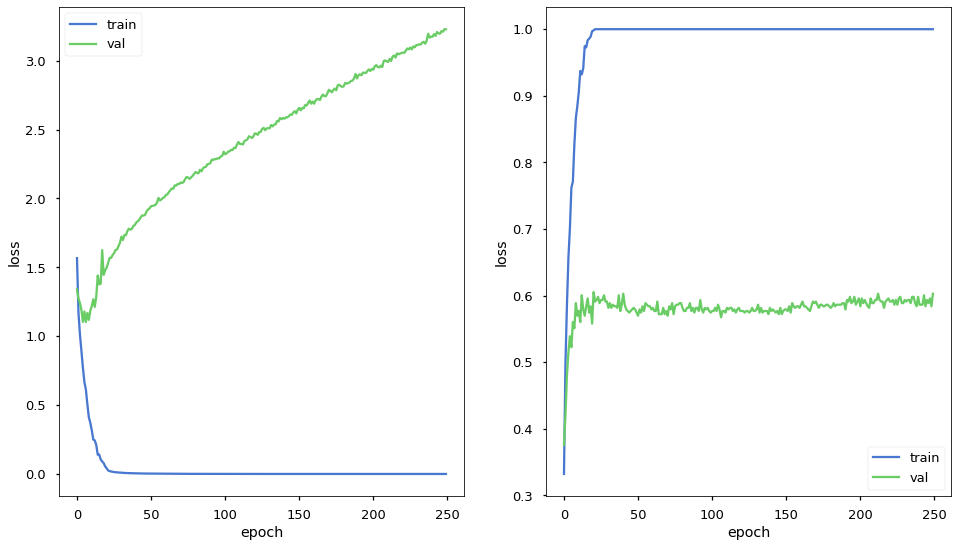

In [48]:
hist = loss_hist.history

plt.subplot(1,2,1)
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])